# Forecasting Net Prophet

You’re a growth analyst at [MercadoLibre](http://investor.mercadolibre.com/about-us). With over 200 million users, MercadoLibre is the most popular e-commerce site in Latin America. You've been tasked with analyzing the company's financial and user data in clever ways to make the company grow. So, you want to find out if the ability to predict search traffic can translate into the ability to successfully trade the stock.

The instructions for this Challenge are divided into four steps, as follows:

* Step 1: Find unusual patterns in hourly Google search traffic

* Step 2: Mine the search traffic data for seasonality

* Step 3: Relate the search traffic to stock price patterns

* Step 4: Create a time series model with Prophet

The following subsections detail these steps.

## Install and import the required libraries and dependencies

In [1]:
# Install the required libraries
!pip install prophet

In [2]:
# Import the required libraries and dependencies
import pandas as pd
from prophet import Prophet
import datetime as dt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

## Step 1: Find Unusual Patterns in Hourly Google Search Traffic

The data science manager asks if the Google search traffic for the company links to any financial events at the company. Or, does the search traffic data just present random noise? To answer this question, pick out any unusual patterns in the Google search data for the company, and connect them to the corporate financial events.

To do so, complete the following steps:

1. Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

2. Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?


#### Step 1: Read the search data into a DataFrame, and then slice the data to just the month of May 2020. (During this month, MercadoLibre released its quarterly financial results.) Visualize the results. Do any unusual patterns exist?

In [3]:
# Store the data in a Pandas DataFrame
# Set the "Date" column as the Datetime Index.

df_mercado_trends = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/google_hourly_search_trends.csv",
    index_col='Date',
    parse_dates=True
).dropna()

# Review the first and last five rows of the DataFrame
display(df_mercado_trends.head())
display(df_mercado_trends.tail())

C:\Users\KD\AppData\Local\Temp\ipykernel_15408\1669825240.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_mercado_trends = pd.read_csv(


,Search Trends
Date,
2016-06-01 00:00:00,97
2016-06-01 01:00:00,92
2016-06-01 02:00:00,76
2016-06-01 03:00:00,60
2016-06-01 04:00:00,38


,Search Trends
Date,
2020-09-07 20:00:00,71
2020-09-07 21:00:00,83
2020-09-07 22:00:00,96
2020-09-07 23:00:00,97
2020-09-08 00:00:00,96


In [4]:
# Review the data types of the DataFrame using the info function
df_mercado_trends.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37106 entries, 2016-06-01 00:00:00 to 2020-09-08 00:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   Search Trends  37106 non-null  int64
dtypes: int64(1)
memory usage: 579.8 KB


<Figure size 600x400 with 0 Axes>

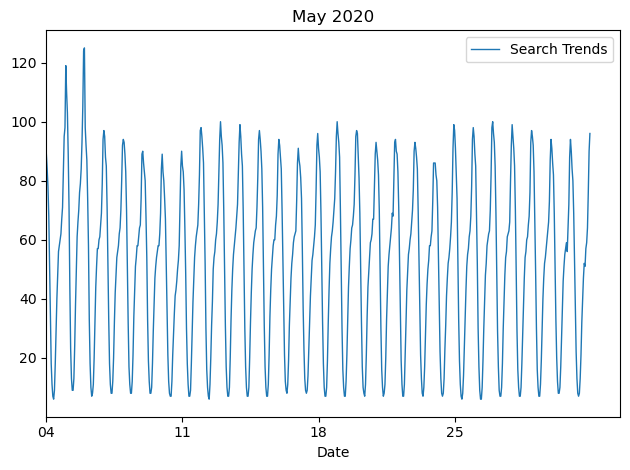

In [5]:
import matplotlib.dates as mthdates
import datetime as dt

# Slice the DataFrame to just the month of May 2020
#display(df_mercado_trends)
may_2020_data = df_mercado_trends[(df_mercado_trends.index.month == 5 )& (df_mercado_trends.index.year ==2020)]

# Plot to visualize the data for May 2020
plt.figure(figsize=(6, 4))
fig, ax = plt.subplots()
p1 = ax.plot( may_2020_data['Search Trends'],linewidth=1,label='Search Trends')
ax.legend()
plt.title('May 2020')
plt.xlabel('Date')

# Format the x-axis to display only the day
plt.gca().xaxis.set_major_formatter(mthdates.DateFormatter('%d'))
tick_positions = ['2020-05-04', '2020-05-11', '2020-05-18', '2020-05-25']
tick_positions = [dt.datetime.strptime(date_str, '%Y-%m-%d') for date_str in tick_positions]

plt.xticks(tick_positions, tick_positions)

plt.gca().xaxis.set_major_formatter(mthdates.DateFormatter('%d'))
plt.grid(False)
plt.xlim(xmin=tick_positions[0])
plt.tight_layout()
plt.show()


#### Step 2: Calculate the total search traffic for the month, and then compare the value to the monthly median across all months. Did the Google search traffic increase during the month that MercadoLibre released its financial results?

In [6]:
# Calculate the sum of the total search traffic for May 2020
traffic_may_2020=may_2020_data['Search Trends'].sum()

# View the traffic_may_2020 value
print('Search Trends    {}'.format(traffic_may_2020))
print(type(traffic_may_2020))

Search Trends    38181
<class 'numpy.int64'>


In [7]:
# Calcluate the monhtly median search traffic across all months
# Group the DataFrame by index year and then index month, chain the sum and then the median functions
median_monthly_traffic=df_mercado_trends.groupby([df_mercado_trends.index.year, df_mercado_trends.index.month])['Search Trends'].sum().median()

# View the median_monthly_traffic value

print('Monthly median search traffic across all months: {}'.format(median_monthly_traffic))
print(type(median_monthly_traffic))


Monthly median search traffic across all months: 35172.5
<class 'float'>


In [8]:
# Compare the seach traffic for the month of May 2020 to the overall monthly median value
corelation_median_value = traffic_may_2020/median_monthly_traffic
print('The corelation of the seach traffic for the month of May 2020 to the overall monthly median value: {:.6f}'.format(corelation_median_value))
print(type(corelation_median_value))

The corelation of the seach traffic for the month of May 2020 to the overall monthly median value: 1.085536
<class 'numpy.float64'>


##### Answer the following question:

**Question:** Did the Google search traffic increase during the month that MercadoLibre released its financial results?

**Answer:**   1.085536 is greater than 1 it shows traffic for May is grater than other months.   

## Step 2: Mine the Search Traffic Data for Seasonality

Marketing realizes that they can use the hourly search data, too. If they can track and predict interest in the company and its platform for any time of day, they can focus their marketing efforts around the times that have the most traffic. This will get a greater return on investment (ROI) from their marketing budget.

To that end, you want to mine the search traffic data for predictable seasonal patterns of interest in the company. To do so, complete the following steps:

1. Group the hourly search data to plot the average traffic by the hour of day. Does the search traffic peak at a particular time of day or is it relatively consistent?

2. Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday). Does the search traffic get busiest on any particular day of the week?

3. Group the hourly search data to plot the average traffic by the week of the year. Does the search traffic tend to increase during the winter holiday period (weeks 40 through 52)?


#### Step 1: Group the hourly search data to plot the average traffic by the hour of the day.

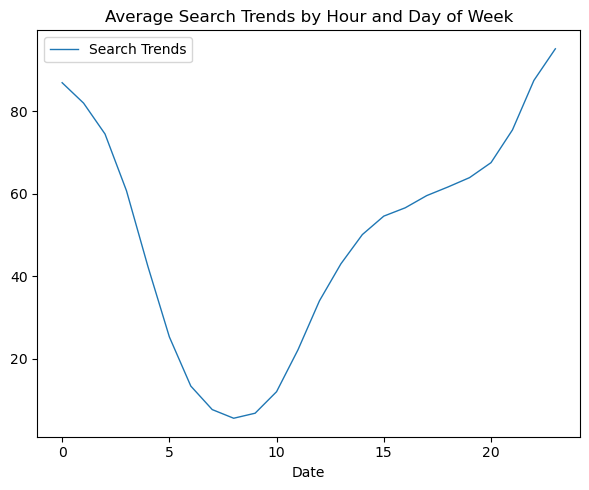

In [9]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.hour`
average_traffic_by_day_hour = df_mercado_trends.groupby([df_mercado_trends.index.dayofweek, df_mercado_trends.index.hour])['Search Trends'].mean()
#display(average_traffic_by_day_hour)

# Plot to visualize the data 
fig, axAvg = plt.subplots(figsize=(6, 5))

# Extract hourly data for the given day
hourly_data = average_traffic_by_day_hour.loc[0]

# Plotting with proper labels
axAvg.plot(
    hourly_data.index, 
    hourly_data.values, 
    label=f'Search Trends',
    linewidth=1
)

# Add axis labels and title
axAvg.set_xlabel('Date')
axAvg.set_title('Average Search Trends by Hour and Day of Week')

# Add a legend
axAvg.legend()

# Display the plot
plt.tight_layout()
plt.show()



#### Step 2: Group the hourly search data to plot the average traffic by the day of the week (for example, Monday vs. Friday).

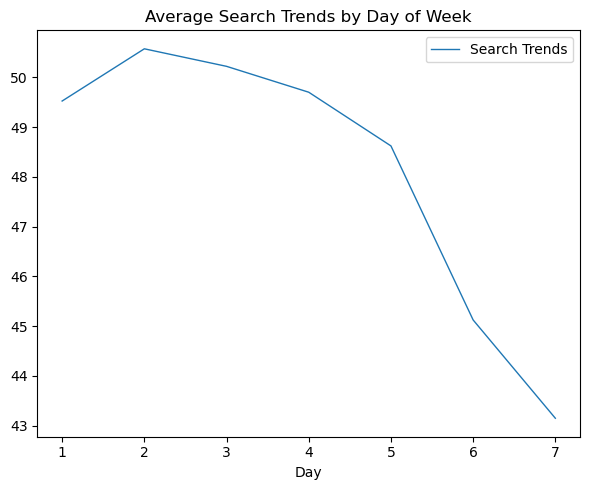

In [10]:
# Group the hourly search data to plot the average traffic by the day of week, using `df.index.isocalendar().day`.
average_traffic_by_iso_day= df_mercado_trends.groupby( df_mercado_trends.index.isocalendar().day)['Search Trends'].mean()

fig, axIso = plt.subplots(figsize=(6, 5))

# Extract hourly data for the given day
day_data = average_traffic_by_iso_day

# Plotting with proper labels
axIso.plot(
    day_data.index, 
    day_data.values, 
    label=f'Search Trends',
    linewidth=1
)

# Add axis labels and title
axIso.set_xlabel('Day')
axIso.set_title('Average Search Trends by Day of Week')

# Add a legend
axIso.legend()

# Display the plot
plt.tight_layout()
plt.show()


#### Step 3: Group the hourly search data to plot the average traffic by the week of the year.

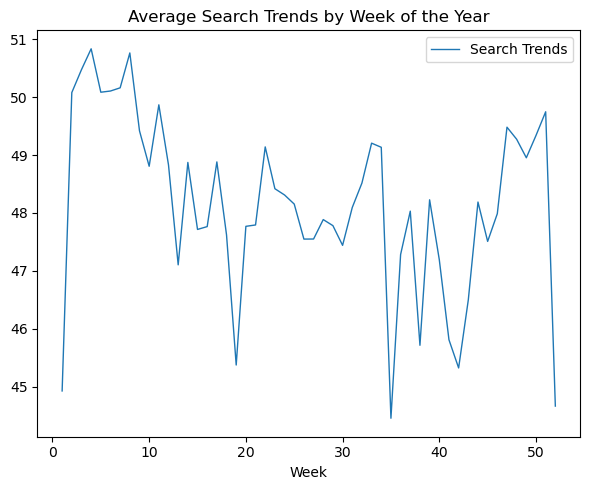

In [11]:
# Group the hourly search data to plot the average traffic by the week of the year using `df.index.isocalendar().week`.
average_traffic_by_iso_week= df_mercado_trends.groupby(  df_mercado_trends.index.isocalendar().week)['Search Trends'].mean()
# display(average_traffic_by_iso_week)

# Step 2: Group by week of the year and calculate the average
fig, axWk = plt.subplots(figsize=(6, 5))

# Plotting with proper labels
axWk.plot(
    average_traffic_by_iso_week.index, 
    average_traffic_by_iso_week.values, 
    label=f'Search Trends',
    linewidth=1
)

# Add axis labels and title
axWk.set_xlabel('Week')
axWk.set_title('Average Search Trends by Week of the Year')

# Add a legend
axWk.legend()

# Display the plot
plt.tight_layout()
plt.show()

##### Answer the following question:

**Question:** Are there any time based trends that you can see in the data?

**Answer:** 
- Average search traffic is Low between 5am and 10 am.
- There is a significant drop in traffic on weekends.
- There is a significant drop in traffic around Dec - Jan , Apr - May and Aug-Sep timeframes.


## Step 3: Relate the Search Traffic to Stock Price Patterns

You mention your work on the search traffic data during a meeting with people in the finance group at the company. They want to know if any relationship between the search data and the company stock price exists, and they ask if you can investigate.

To do so, complete the following steps:

1. Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

2. Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

3. Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

    * “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

    * “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis

4. Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?


#### Step 1: Read in and plot the stock price data. Concatenate the stock price data to the search data in a single DataFrame.

In [12]:
# Upload the "mercado_stock_price.csv" file into Colab, then store in a Pandas DataFrame
# Set the "date" column as the Datetime Index.
df_mercado_stock = pd.read_csv(
    "https://static.bc-edx.com/ai/ail-v-1-0/m8/lms/datasets/mercado_stock_price.csv",
    index_col="date",
    parse_dates=True
).dropna()

# View the first and last five rows of the DataFrame 
display(df_mercado_stock.head())
display(df_mercado_stock.tail())

,close
date,
2015-01-02 09:00:00,127.67
2015-01-02 10:00:00,125.44
2015-01-02 11:00:00,125.57
2015-01-02 12:00:00,125.40
2015-01-02 13:00:00,125.17


,close
date,
2020-07-31 11:00:00,1105.780
2020-07-31 12:00:00,1087.925
2020-07-31 13:00:00,1095.800
2020-07-31 14:00:00,1110.650
2020-07-31 15:00:00,1122.510


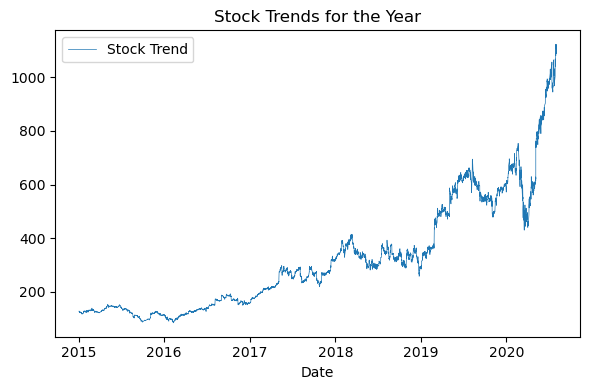

In [13]:
# Visualize the closing price of the df_mercado_stock DataFrame
fig, axstk = plt.subplots(figsize=(6, 4))  # Set the figure size

# Plotting with proper labels
axstk.plot(
    df_mercado_stock.index, 
    df_mercado_stock['close'],
    label=f'Stock Trend',
    linewidth=0.5
)

# Add axis labels and title
axstk.set_xlabel('Date')
axstk.set_title('Stock Trends for the Year')

# Add a legend
axstk.legend()

# Display the plot
plt.tight_layout()
plt.show()





In [14]:
# Concatenate the df_mercado_stock DataFrame with the df_mercado_trends DataFrame
# Concatenate the DataFrame by columns (axis=1), and drop and rows with only one column of data

combined_df = pd.concat([df_mercado_stock, df_mercado_trends], axis=1)
# non_nan_count = combined_df.count(axis=1) 
clean_corel_df= combined_df.dropna()
# clean_corel_df=combined_df[non_nan_count>1]

# View the first and last five rows of the DataFrame
display(clean_corel_df.head(5))
display(clean_corel_df.tail(5))


,close,Search Trends
2016-06-01 09:00:00,135.16,6.0
2016-06-01 10:00:00,136.63,12.0
2016-06-01 11:00:00,136.56,22.0
2016-06-01 12:00:00,136.42,33.0
2016-06-01 13:00:00,136.10,40.0


,close,Search Trends
2020-07-31 11:00:00,1105.780,20.0
2020-07-31 12:00:00,1087.925,32.0
2020-07-31 13:00:00,1095.800,41.0
2020-07-31 14:00:00,1110.650,47.0
2020-07-31 15:00:00,1122.510,53.0


#### Step 2: Market events emerged during the year of 2020 that many companies found difficult. But, after the initial shock to global financial markets, new customers and revenue increased for e-commerce platforms. Slice the data to just the first half of 2020 (`2020-01` to `2020-06` in the DataFrame), and then plot the data. Do both time series indicate a common trend that’s consistent with this narrative?

In [15]:
# For the combined dataframe, slice to just the first half of 2020 (2020-01 through 2020-06)
corel_subset_df = clean_corel_df['2020-01' :'2020-06']

# View the first and last five rows of first_half_2020 DataFrame
display(corel_subset_df.head(5))
display(corel_subset_df.tail(5))

,close,Search Trends
2020-01-02 09:00:00,601.085,9.0
2020-01-02 10:00:00,601.290,14.0
2020-01-02 11:00:00,615.410,25.0
2020-01-02 12:00:00,611.400,37.0
2020-01-02 13:00:00,611.830,50.0


,close,Search Trends
2020-06-30 11:00:00,976.17,17.0
2020-06-30 12:00:00,977.50,27.0
2020-06-30 13:00:00,973.23,37.0
2020-06-30 14:00:00,976.50,45.0
2020-06-30 15:00:00,984.93,51.0


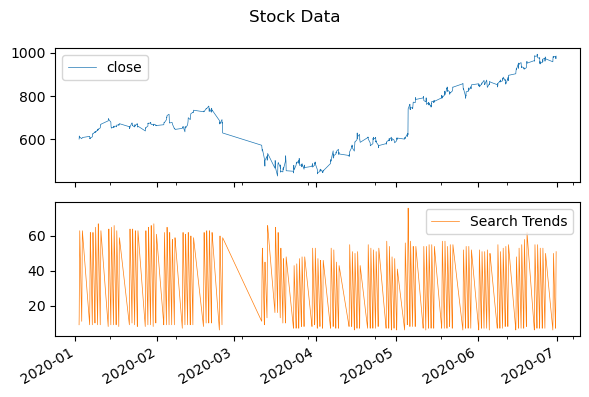

In [16]:
# Visualize the close and Search Trends data
# Plot each column on a separate axes using the following syntax
# `plot(subplots=True)`

# Plot subplots for each column
corel_subset_df.plot(subplots=True, layout=(2, 1), figsize=(6, 4), title="Stock Data",linewidth=0.5)

# Display the plot
plt.tight_layout()
plt.show()

##### Answer the following question:

**Question:** Do both time series indicate a common trend that’s consistent with this narrative?

**Answer:** The Highs and Lows of the stock close value 
match that of the search trends data.

#### Step 3: Create a new column in the DataFrame named “Lagged Search Trends” that offsets, or shifts, the search traffic by one hour. Create two additional columns:

* “Stock Volatility”, which holds an exponentially weighted four-hour rolling average of the company’s stock volatility

* “Hourly Stock Return”, which holds the percent change of the company's stock price on an hourly basis


In [17]:
# Create a new column in the mercado_stock_trends_df DataFrame called Lagged Search Trends
# This column should shift the Search Trends information by one hour
mercado_stock_trends_df=clean_corel_df #corel_subset_df

mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)
# mercado_stock_trends_df=mercado_stock_trends_df.dropna()
display(mercado_stock_trends_df.head(5))
display(mercado_stock_trends_df.tail(5))


C:\Users\KD\AppData\Local\Temp\ipykernel_15408\2515564921.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mercado_stock_trends_df['Lagged Search Trends'] = mercado_stock_trends_df['Search Trends'].shift(1)


,close,Search Trends,Lagged Search Trends
2016-06-01 09:00:00,135.16,6.0,NaN
2016-06-01 10:00:00,136.63,12.0,6.0
2016-06-01 11:00:00,136.56,22.0,12.0
2016-06-01 12:00:00,136.42,33.0,22.0
2016-06-01 13:00:00,136.10,40.0,33.0


,close,Search Trends,Lagged Search Trends
2020-07-31 11:00:00,1105.780,20.0,11.0
2020-07-31 12:00:00,1087.925,32.0,20.0
2020-07-31 13:00:00,1095.800,41.0,32.0
2020-07-31 14:00:00,1110.650,47.0,41.0
2020-07-31 15:00:00,1122.510,53.0,47.0


In [18]:
# Create a new column in the mercado_stock_trends_df DataFrame called Stock Volatility
# This column should calculate the standard deviation of the closing stock price return data over a 4 period rolling window

# Calculate the standard deviation over a 4-period rolling window
mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['close'].pct_change().rolling(window=4).std()
# mercado_stock_trends_df=mercado_stock_trends_df.dropna()
display(mercado_stock_trends_df.head(5))
display(mercado_stock_trends_df.tail(5))

C:\Users\KD\AppData\Local\Temp\ipykernel_15408\3435987552.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mercado_stock_trends_df['Stock Volatility'] = mercado_stock_trends_df['close'].pct_change().rolling(window=4).std()


,close,Search Trends,Lagged Search Trends,Stock Volatility
2016-06-01 09:00:00,135.16,6.0,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN
2016-06-01 11:00:00,136.56,22.0,12.0,NaN
2016-06-01 12:00:00,136.42,33.0,22.0,NaN
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134


,close,Search Trends,Lagged Search Trends,Stock Volatility
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001
2020-07-31 15:00:00,1122.510,53.0,47.0,0.013566


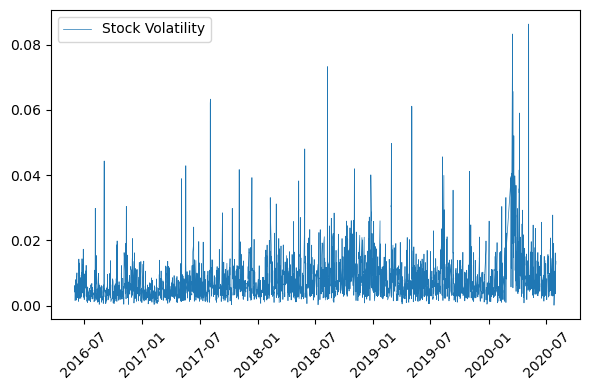

In [19]:
# Visualize the stock volatility

# Visualize the closing price of the df_mercado_stock DataFrame
fig, axsv = plt.subplots(figsize=(6, 4))  # Set the figure size

# Plotting with proper labels
axsv.plot(
    mercado_stock_trends_df.index, 
    mercado_stock_trends_df['Stock Volatility'],
    label=f'Stock Volatility',
    linewidth=0.5    
)
# Add a legend
axsv.legend()
plt.xticks(rotation=45)
# Display the plot
plt.tight_layout()
plt.show()


**Solution Note:** Note how volatility spiked, and tended to stay high, during the first half of 2020. This is a common characteristic of volatility in stock returns worldwide: high volatility days tend to be followed by yet more high volatility days. When it rains, it pours.

In [20]:
# Create a new column in the mercado_stock_trends_df DataFrame called Hourly Stock Return
# This column should calculate hourly return percentage of the closing price
mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()
display(mercado_stock_trends_df.head(5))
display(mercado_stock_trends_df.tail(5))

C:\Users\KD\AppData\Local\Temp\ipykernel_15408\2677300419.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mercado_stock_trends_df['Hourly Stock Return'] = mercado_stock_trends_df['close'].pct_change()


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2016-06-01 09:00:00,135.16,6.0,NaN,NaN,NaN
2016-06-01 10:00:00,136.63,12.0,6.0,NaN,0.010876
2016-06-01 11:00:00,136.56,22.0,12.0,NaN,-0.000512
2016-06-01 12:00:00,136.42,33.0,22.0,NaN,-0.001025
2016-06-01 13:00:00,136.10,40.0,33.0,0.006134,-0.002346


,close,Search Trends,Lagged Search Trends,Stock Volatility,Hourly Stock Return
2020-07-31 11:00:00,1105.780,20.0,11.0,0.012837,0.006380
2020-07-31 12:00:00,1087.925,32.0,20.0,0.013549,-0.016147
2020-07-31 13:00:00,1095.800,41.0,32.0,0.013295,0.007239
2020-07-31 14:00:00,1110.650,47.0,41.0,0.013001,0.013552
2020-07-31 15:00:00,1122.510,53.0,47.0,0.013566,0.010678


#### Step 4: Review the time series correlation, and then answer the following question: Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

In [21]:
# Construct correlation table of Stock Volatility, Lagged Search Trends, and Hourly Stock Return
mercado_stock_trends_df[['Stock Volatility', 'Lagged Search Trends', 'Hourly Stock Return']].corr()

,Stock Volatility,Lagged Search Trends,Hourly Stock Return
Stock Volatility,1.000000,-0.148938,0.061424
Lagged Search Trends,-0.148938,1.000000,0.017929
Hourly Stock Return,0.061424,0.017929,1.000000


##### Answer the following question:


**Question:** Does a predictable relationship exist between the lagged search traffic and the stock volatility or between the lagged search traffic and the stock price returns?

**Answer:**
- **lagged search traffic and the stock volatility** The correlation is -0.148940, which indicates a weak negative relationship. This suggests that as search traffic increases, stock volatility tends to decrease slightly. Given the low value of the correlation, it's not a good indicator to suggest a reliable or predictable relationship.
- **lagged search traffic and the stock price returns** The correlation is 0.017929 , which is very close to zero. This indicates no clear linear relationship between lagged search traffic and stock price returns. This implies that changes in search trends do not reliably predict changes in stock returns.

## Step 4: Create a Time Series Model with Prophet

Now, you need to produce a time series model that analyzes and forecasts patterns in the hourly search data. To do so, complete the following steps:

1. Set up the Google search data for a Prophet forecasting model.

2. After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

3. Plot the individual time series components of the model to answer the following questions:

    * What time of day exhibits the greatest popularity?

    * Which day of the week gets the most search traffic?

    * What's the lowest point for search traffic in the calendar year?


#### Step 1: Set up the Google search data for a Prophet forecasting model.

In [32]:
# Using the df_mercado_trends DataFrame, reset the index so the date information is no longer the index
mercado_prophet_df = df_mercado_trends.reset_index()

# Label the columns ds and y so that the syntax is recognized by Prophet
mercado_prophet_df.rename(columns={'Date': 'ds', 'Search Trends': 'y'},inplace=True)

# Drop an NaN values from the prophet_df DataFrame
mercado_prophet_df=mercado_prophet_df.dropna()

# View the first and last five rows of the mercado_prophet_df DataFrame
display(mercado_prophet_df.head(5))
display(mercado_prophet_df.tail(5))

,ds,y
0,2016-06-01 00:00:00,97
1,2016-06-01 01:00:00,92
2,2016-06-01 02:00:00,76
3,2016-06-01 03:00:00,60
4,2016-06-01 04:00:00,38


,ds,y
37101,2020-09-07 20:00:00,71
37102,2020-09-07 21:00:00,83
37103,2020-09-07 22:00:00,96
37104,2020-09-07 23:00:00,97
37105,2020-09-08 00:00:00,96


In [33]:
# Call the Prophet function, store as an object
prophet_model = Prophet()

In [34]:
# Fit the time-series model.
prophet_model.fit(mercado_prophet_df,)

22:11:56 - cmdstanpy - INFO - Chain [1] start processing
22:12:21 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# Create a future dataframe to hold predictions
# Make the prediction go out as far as 2000 hours (approx 80 days)
# 'H' for hourly
future_mercado_trends = prophet_model.make_future_dataframe(periods=2000, freq='H') 

# View the last five rows to confirm it's the expected length
print(future_mercado_trends.tail())
# View the last five rows of the future_mercado_trends DataFrame


                       ds
39101 2020-11-30 04:00:00
39102 2020-11-30 05:00:00
39103 2020-11-30 06:00:00
39104 2020-11-30 07:00:00
39105 2020-11-30 08:00:00


In [40]:
# Make the predictions for the trend data using the future_mercado_trends DataFrame
forecast_mercado_trends = prophet_model.predict(future_mercado_trends)

# Display the first five rows of the forecast_mercado_trends DataFrame
display(forecast_mercado_trends.head(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2016-06-01 00:00:00,44.352625,81.788632,98.545241,44.352625,44.352625,45.307367,45.307367,45.307367,41.452720,...,1.860390,1.860390,1.860390,1.994257,1.994257,1.994257,0.0,0.0,0.0,89.659992
1,2016-06-01 01:00:00,44.353557,78.001769,94.535395,44.353557,44.353557,41.753097,41.753097,41.753097,37.943514,...,1.810288,1.810288,1.810288,1.999294,1.999294,1.999294,0.0,0.0,0.0,86.106654
2,2016-06-01 02:00:00,44.354489,66.936739,83.813511,44.354489,44.354489,31.429548,31.429548,31.429548,27.656552,...,1.768695,1.768695,1.768695,2.004301,2.004301,2.004301,0.0,0.0,0.0,75.784037
3,2016-06-01 03:00:00,44.355421,52.170635,69.830932,44.355421,44.355421,16.162280,16.162280,16.162280,12.417302,...,1.735704,1.735704,1.735704,2.009275,2.009275,2.009275,0.0,0.0,0.0,60.517701
4,2016-06-01 04:00:00,44.356353,34.974243,51.589892,44.356353,44.356353,-0.952639,-0.952639,-0.952639,-4.678127,...,1.711270,1.711270,1.711270,2.014218,2.014218,2.014218,0.0,0.0,0.0,43.403713


#### Step 2: After estimating the model, plot the forecast. How's the near-term forecast for the popularity of MercadoLibre?

c:\Users\KD\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\KD\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


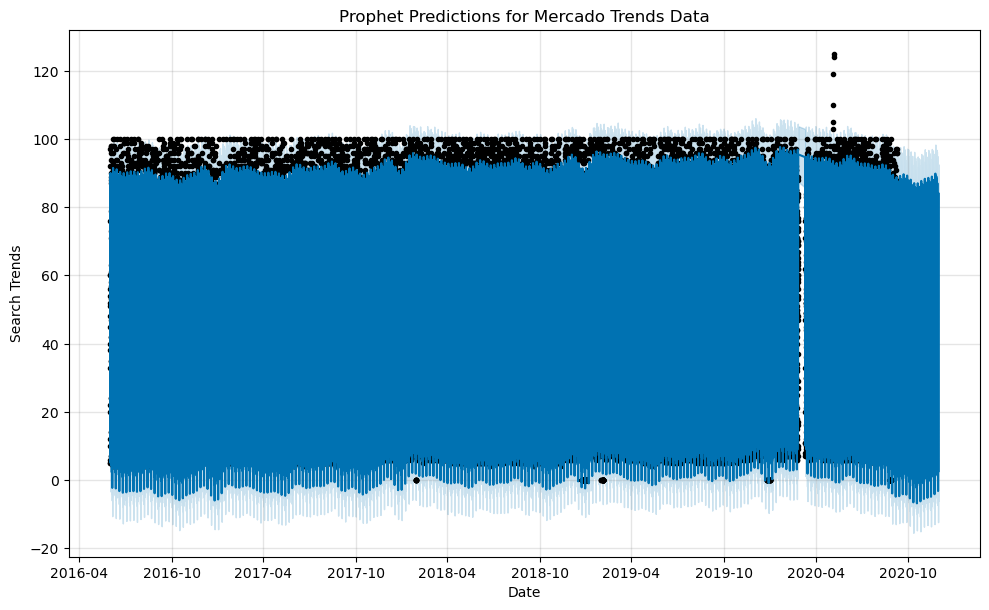

In [44]:
# Plot the Prophet predictions for the Mercado trends data
fig = prophet_model.plot(forecast_mercado_trends, xlabel='Date', ylabel='Search Trends')

# fig2=prophet_model.plot_components(forecast_mercado_trends)
# Add a title to the plot
plt.title('Prophet Predictions for Mercado Trends Data')

# Display the plot
plt.show()

##### Answer the following question:

**Question:**  How's the near-term forecast for the popularity of MercadoLibre?

**Answer:** Forecast shows a dip in the near-term popularity of MercadoLibre


#### Step 3: Plot the individual time series components of the model to answer the following questions:

* What time of day exhibits the greatest popularity?

* Which day of the week gets the most search traffic?

* What's the lowest point for search traffic in the calendar year?


In [62]:
forecast_mercado_trends.reset_index(inplace=True)
# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
forecast_mercado_trends.set_index('ds',inplace=True)
# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
display(forecast_mercado_trends.filter(['yhat','yhat_lower','yhat_upper']).head(5))

,yhat,yhat_lower,yhat_upper
ds,,,
2016-06-01 00:00:00,89.659992,81.788632,98.545241
2016-06-01 01:00:00,86.106654,78.001769,94.535395
2016-06-01 02:00:00,75.784037,66.936739,83.813511
2016-06-01 03:00:00,60.517701,52.170635,69.830932
2016-06-01 04:00:00,43.403713,34.974243,51.589892


Solutions Note: `yhat` represents the most likely (average) forecast, whereas `yhat_lower` and `yhat_upper` represents the worst and best case prediction (based on what are known as 95% confidence intervals).

Timestamp('2020-11-30 08:00:00')

Timestamp('2020-09-08 00:00:00')

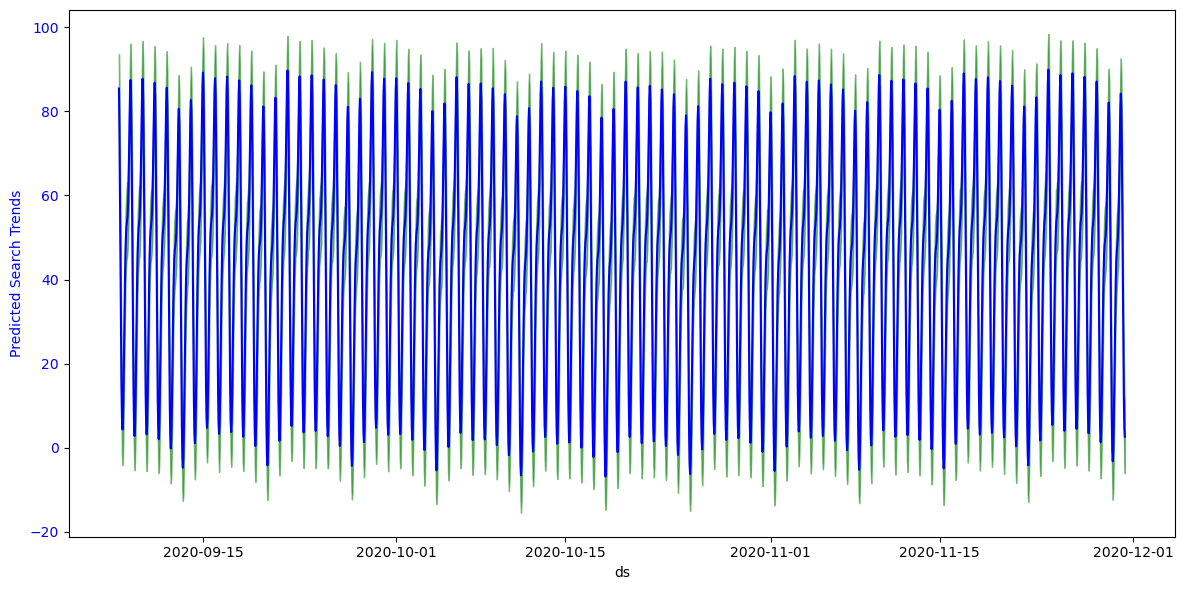

In [93]:
# From the forecast_mercado_trends DataFrame, plot the data to visualize
#  the yhat, yhat_lower, and yhat_upper columns over the last 2000 hours

forecast_2000_hours = forecast_mercado_trends.tail(2000) 


max_dt = forecast_2000_hours.index[-1]
display(max_dt)
date_2000_hours_ago = max_dt - pd.Timedelta(hours=2000)

display(date_2000_hours_ago)
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the primary data on ax1 (yhat, yhat_lower, yhat_upper)
ax1.plot(forecast_2000_hours.index, forecast_2000_hours['yhat'], 'b-', label='yhat')  # Blue line for yhat
ax1.fill_between(
    forecast_2000_hours.index,
    forecast_2000_hours['yhat_lower'],
    forecast_2000_hours['yhat_upper'],
    color='green',
    alpha=0.5,
)
ax1.set_xlabel('ds')  # Common x-axis
ax1.set_ylabel('Predicted Search Trends', color='b')  # Blue y-axis
ax1.tick_params(axis='y', labelcolor='b')  # Set the y-axis label color to match the plot

plt.tight_layout()
# Display the plot
plt.show()

c:\Users\KD\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
c:\Users\KD\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:397: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  artists += ax.plot(df_y['ds'].dt.to_pydatetime(), seas[name], ls='-',
c:\Users\KD\anaconda3\envs\dev\lib\site-packages\prophet\plot.py:401: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain th

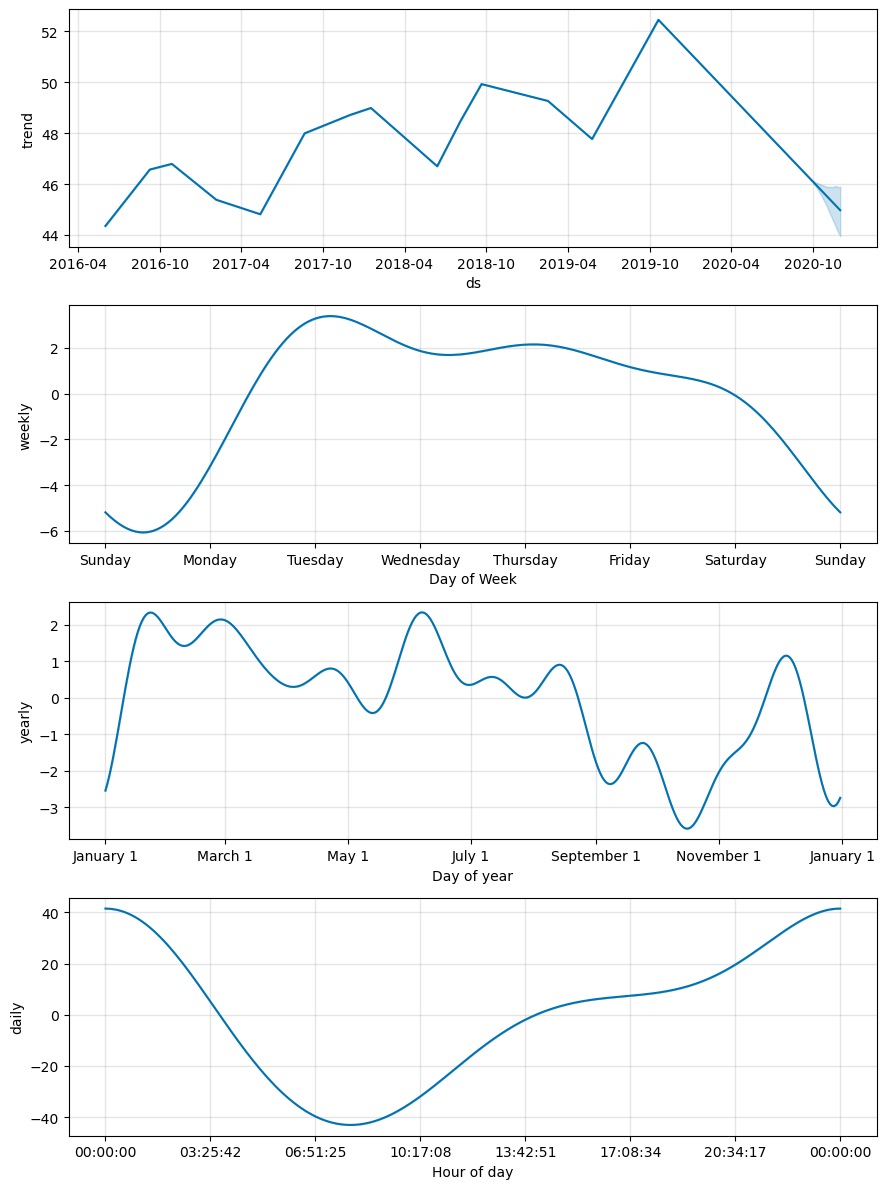

In [96]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_mercado_trends.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results
# for the forecast_canada DataFrame ###### not sure what this is
fig=prophet_model.plot_components(forecast_mercado_trends)

# Display the plot
plt.show()


##### Answer the following questions:

**Question:** What time of day exhibits the greatest popularity?

**Answer:** 12 am exhibits the greatest popularity?

**Question:** Which day of week gets the most search traffic?
   
**Answer:** Tuesday gets the most traffic

**Question:** What's the lowest point for search traffic in the calendar year?

**Answer:** October is the lowest point for search traffic in the calendar year
